## Distribution of Trump's Tweets from Various Devices

This notebook reproduces part of the analysis here: http://varianceexplained.org/r/trump-tweets/.
It explores the distribution of Trump's tweets from iPhone and Android as a function of week day, date, and time of the day.

In [1]:
import os
import sys
import re

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pylab as plt
pd.set_option('max_colwidth',150)

The data saved by running the notebook `Grab Trump's Tweets` is loaded with `Pandas`.

In [2]:
root_dir = "/Users/gogrean/Documents/kaggle/off_kaggle_ds/elect2016/data/"
df = pd.read_csv(root_dir + "trumps_tweets.csv")

The date of the tweets is saved in the `created_at` field. This field saves the date as, e.g.

`Sat Dec 12 19:21:15 +0000 2015`

so this needs to be pre-processed to separate the day of the week, the date, and the time. The time field is further converted to an hour field by rounding the time to the nearest full hour.

In [3]:
df['day_of_week'] = [data[0:3] for data in df['created_at']]
df['date'] = [data[-4:] + data[3:10] for data in df['created_at']]
df['time'] = [data[11:19] for data in df['created_at']]

# round to the nearest hour and subtract 3 to get from PST to EST
df['hour'] = np.floor(pd.to_datetime(df.time).dt.hour.values + 0.5) - 3 

Different devices are plotted in different colors:

Color | Device
--- | ---
ORANGE | Android
BLUE | iPhone

In [4]:
color = ['orange', 'blue']

I also save the days of the week ordered in a list so that I can later reindex the dataframes corresponding to tweets from the individual devices.

In [5]:
weekday_ticks = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

I group the tweets by source, select the `day_of_week` column, and apply the `value_counts` function to get the number of tweets posted each day of the week from each device. There are very few tweets coming from Instagram, iPad, and Mobile Web (M5), and not many from the Web Client either, so it's not possible to get any sort of robust statistics for these devices/services. Therefore, I remove tweets from these devices for this part of the analysis.

In [6]:
grouped_by_source = df.groupby(by=df['source']).day_of_week.value_counts()
sources = grouped_by_source.index.levels[0]
for source in sources:
    if 'Instagram' in source or 'iPad' in source or 'M5' in source or 'Web Client' in source:
        sources = sources.drop(source)

`Pandas` bar plots allow a `positions` parameter that sets the location of the bins. The position is a float between 0 (all the way left) and 1 (all the way right). I define the positions so that the bars partly overlap. Later I make the bars partly transparent.

In [7]:
position_of_bins = [0.25, 0.75]

Finally, I plot the percentage of tweets posted from each device as a function of day of the week. This requires reindexing the grouped_by_source[source] series to have the days in consecutive order.

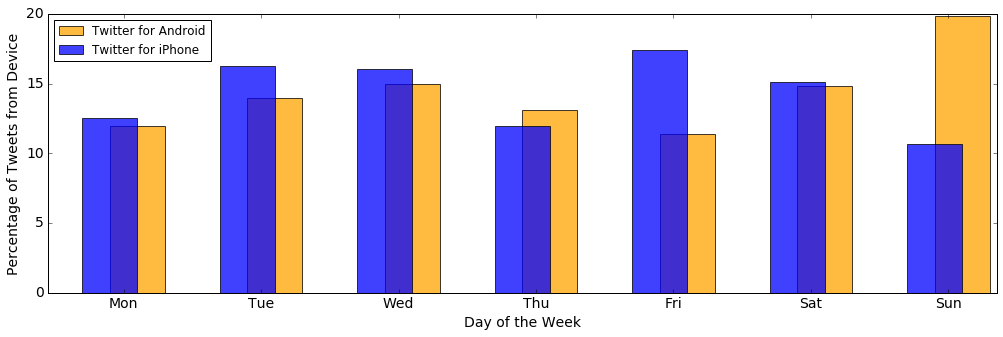

In [8]:
root_dir = "/Users/gogrean/Documents/kaggle/off_kaggle_ds/elect2016/"
fig, ax = plt.subplots(1, figsize=(17,5))

for source, col, pos in zip(sources, color, position_of_bins):
    ordered_by_weekday = grouped_by_source[source].reindex(weekday_ticks) / grouped_by_source[source].sum() * 100.
    stripped_source = re.sub(r'<.*?>', r'', source)
    ordered_by_weekday.plot(kind='bar', ax=ax, color=col, alpha=0.75, 
                            label=stripped_source, position=pos, rot=0,
                            fontsize=14, width=0.4)
plt.xlabel('Day of the Week', fontsize=14)
plt.ylabel('Percentage of Tweets from Device', fontsize=14)
plt.legend(loc='best')
plt.savefig(root_dir + "figs/trump_tweets_from_device_vs_day_of_week.pdf")

Similarly, I also plot the percentage of tweets from individual devices as a function of time.

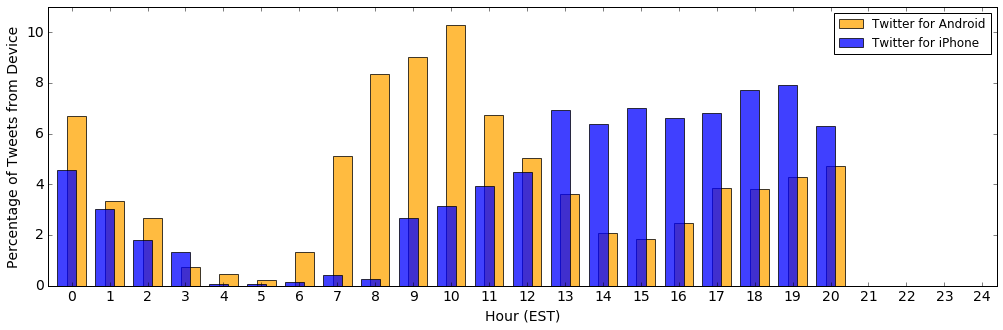

In [9]:
grouped_by_source = df.groupby(by=df['source']).hour.value_counts()
sources = grouped_by_source.index.levels[0]
for source in sources:
    if 'Instagram' in source or 'iPad' in source or 'M5' in source or 'Web Client' in source:
        sources = sources.drop(source)
        
fig, ax = plt.subplots(1, figsize=(17,5))
for source, col, pos in zip(sources, color, position_of_bins):
    ordered_by_hour = grouped_by_source[source].reindex(range(25)) / grouped_by_source[source].sum() * 100.
    stripped_source = re.sub(r'<.*?>', r'', source)
    ordered_by_hour.plot(kind='bar', ax=ax, color=col, alpha=0.75, 
                         label=stripped_source, position=pos, 
                         fontsize=14, rot=0)
plt.xlabel('Hour (EST)', fontsize=14)
plt.ylabel('Percentage of Tweets from Device', fontsize=14)
plt.ylim([0,11])
plt.legend(loc='best')
plt.savefig(root_dir + "figs/trump_tweets_from_device_vs_hour_EST.pdf")

Finally, I plot the percentage of tweets from individual devices as a function of date.

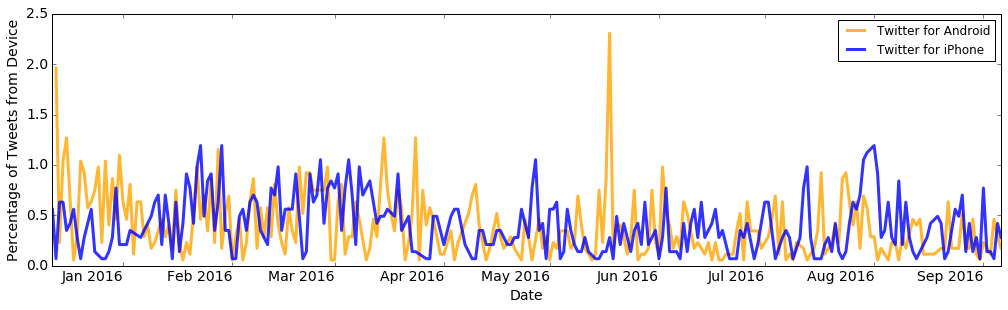

In [10]:
df['date'] = pd.to_datetime(df.date)
grouped_by_source = df.groupby(by=df['source']).date.value_counts()
for source in sources:
    if 'Instagram' in source or 'iPad' in source or 'M5' in source or 'Web Client' in source:
        sources = sources.drop(source)
        
fig, ax = plt.subplots(1, figsize=(17,5))
for source, col in zip(sources, color):
    ordered_by_date = grouped_by_source[source] / grouped_by_source[source].sum() * 100.
    stripped_source = re.sub(r'<.*?>', r'', source)
    ordered_by_date.plot(kind='line', ax=ax, color=col, alpha=0.8, 
                         label=stripped_source, linewidth=3,
                         fontsize=14, rot=0)

plt.xlabel('Date', fontsize=14)
plt.ylabel('Percentage of Tweets from Device', fontsize=14)
plt.legend(loc='best')
plt.savefig(root_dir + "figs/trump_tweets_from_device_vs_date.pdf")

Many of Trump's retweets are copy-pasted tweets of other users, rather than typical Twitter retweets. Is there a difference between the fraction of typical Twitter retweets and copy-pasted tweets posted from Android and iPhone?

In [11]:
from utils import is_copy_paste, is_article_quote

for i, text in enumerate(df.text):
    df.at[i, 'copy_paste'] = is_copy_paste(text)
    df.at[i, 'article_quote'] = is_article_quote(text)

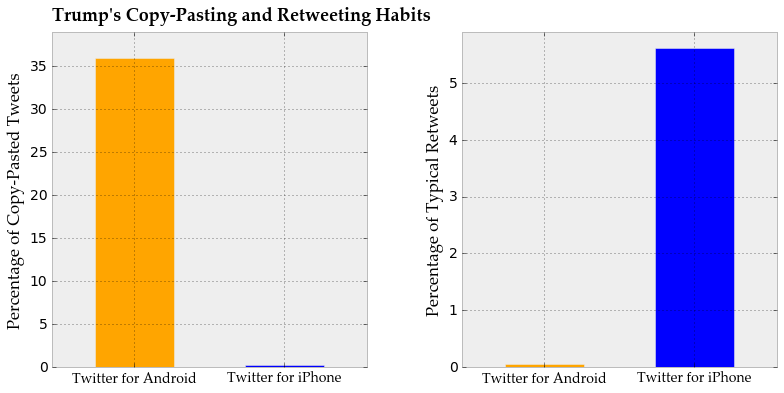

In [12]:
plt.rcParams.update({'font.size': 14})
plt.rcParams['xtick.labelsize'] = 14
pfont = {'fontname': 'Palatino Linotype'}

plt.style.use('bmh')
fig, ax = plt.subplots(1, 2, figsize=(13,6))

bar_pos = [0.31, 0.69]
bar_width = 0.2

grouped_by_source_cp = df.groupby(by=df['source']).copy_paste.value_counts()
sources_cp = grouped_by_source_cp.index.levels[0]
for source in sources_cp:
    if 'Instagram' in source or 'iPad' in source or 'M5' in source or 'Web Client' in source:
        sources_cp = sources_cp.drop(source)
df_cp = grouped_by_source_cp.reset_index()
df_cp = df_cp[df_cp.copy_paste == True]
df_cp.columns = list(df_cp.columns[:-1]) + ["cp_counts"]

stripped_source = []
for pos, source, col in zip(bar_pos, sources_cp, color):
    total = df_cp[df_cp.source == source]['cp_counts'] / len(df[df.source == source]) * 100.
    stripped_source.append(re.sub(r'<.*?>', r'', source))
    ax[0].bar(pos, total, color=col, width=bar_width)
    ax[0].set_xticks([pos + bar_width/2 for pos in bar_pos])
ax[0].set_xticklabels(stripped_source, **pfont)
ax[0].set_ylabel('Percentage of Copy-Pasted Tweets', **pfont)
ax[0].set_ylim([0,39.])
ax[0].set_xlim([0.2,1.0])

grouped_by_source_rt = df.groupby(by=df['source']).is_retweet.value_counts()
sources_rt = grouped_by_source_rt.index.levels[0]
for source in sources_rt:
    if 'Instagram' in source or 'iPad' in source or 'M5' in source or 'Web Client' in source:
        sources_rt = sources_rt.drop(source)
df_rt = grouped_by_source_rt.reset_index()
df_rt = df_rt[df_rt.is_retweet == True]
df_rt.columns = list(df_rt.columns[:-1]) + ["rt_counts"]

stripped_source = []
for pos, source, col in zip(bar_pos, sources_rt, color):
    total = df_rt[df_rt.source == source]['rt_counts'] / len(df[df.source == source]) * 100.
    stripped_source.append(re.sub(r'<.*?>', r'', source))
    ax[1].bar(pos, total, color=col, width=bar_width)
    ax[1].set_xticks([pos + bar_width/2 for pos in bar_pos])
ax[1].set_xticklabels(stripped_source, **pfont)
ax[1].set_ylabel('Percentage of Typical Retweets', **pfont)
ax[1].set_ylim([0,5.9])
ax[1].set_xlim([0.2,1.0])

ax[0].set_title("Trump's Copy-Pasting and Retweeting Habits",
                loc='left', y=1.02, fontsize=18, weight='bold', **pfont)

fig.subplots_adjust(wspace=0.3)

fig.savefig(root_dir + 'figs/copy_pastes_and_retweets_android_vs_iphone.pdf')